# Part 3: Advanced Analysis

In this part, we will implement advanced analysis techniques for physiological time series data, including time-domain feature extraction, frequency analysis, and wavelet transforms.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pywt
from scipy import signal
from pathlib import Path


# Set plotting style
plt.style.use('seaborn')
sns.set_context('notebook')

/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_28306/3865423200.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Time-Domain Feature Extraction

Implement the `extract_time_domain_features` function to extract various time-domain features from physiological signals.

In [7]:
def extract_time_domain_features(data, window_size=60):
    """
    Extract time-domain features from physiological signals.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input data with columns: ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    window_size : int, optional
        Size of the rolling window in seconds, default=60

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing extracted features for each window
    """
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values(by=['subject_id', 'session', 'timestamp'])

    data = data.set_index('timestamp')
    results = []

    for (subject_id, session), group in data.groupby(['subject_id', 'session']):
        window = f'{window_size}s'

        rr_intervals = 60000 / group['heart_rate']
        rr_diff = rr_intervals.diff()

        features = pd.DataFrame(index=group.index)
        features['mean_hr'] = group['heart_rate'].rolling(window).mean()
        features['std_hr'] = group['heart_rate'].rolling(window).std()
        features['min_hr'] = group['heart_rate'].rolling(window).min()
        features['max_hr'] = group['heart_rate'].rolling(window).max()
        features['rmssd'] = rr_diff.rolling(window).apply(lambda x: np.sqrt(np.mean(x**2)) if len(x.dropna()) > 1 else np.nan)
        features['sdnn'] = rr_intervals.rolling(window).std()
        features['pnn50'] = rr_diff.rolling(window).apply(
            lambda x: 100 * np.mean(np.abs(x) > 50) if len(x.dropna()) > 1 else np.nan
        )

        features['mean_eda'] = group['eda'].rolling(window).mean()
        features['mean_temp'] = group['temperature'].rolling(window).mean()
        features['subject_id'] = subject_id
        features['session'] = session
        features = features.reset_index()
        results.append(features)

    return pd.concat(results, ignore_index=True).dropna()


In [8]:
data_dir = Path('/Users/hteshome/Desktop/4-it-s-about-time-haile-teshome/processed_data/')
all_files = list(data_dir.glob("S*_processed.csv"))
dataframes = [pd.read_csv(file) for file in all_files]
preprocessed_data = pd.concat(dataframes, ignore_index=True)
preprocessed_data['timestamp'] = pd.to_datetime(preprocessed_data['timestamp'])

time_domain_df = extract_time_domain_features(preprocessed_data, window_size=60)

time_domain_df.head()


,timestamp,mean_hr,std_hr,min_hr,max_hr,rmssd,sdnn,pnn50,mean_eda,mean_temp,subject_id,session
2,2018-12-05 16:29:09,98.276667,16.834626,82.5,116.0,165.854469,105.016249,66.666667,0.008542,21.89,S1,Final
3,2018-12-05 16:29:10,95.270000,15.003220,82.5,116.0,141.791240,93.228931,75.000000,0.011852,21.89,S1,Final
4,2018-12-05 16:29:11,95.936000,13.078235,82.5,116.0,130.294292,82.015672,80.000000,0.014095,21.89,S1,Final
5,2018-12-05 16:29:12,97.863333,12.614272,82.5,116.0,118.696696,79.675707,83.333333,0.015803,21.89,S1,Final
6,2018-12-05 16:29:13,100.127143,12.979743,82.5,116.0,109.066988,80.940003,71.428571,0.016840,21.89,S1,Final


## 2. Frequency Analysis

Implement the `analyze_frequency_components` function to perform frequency-domain analysis on the signals.

In [4]:
def analyze_frequency_components(data, sampling_rate=1.0, window_size=60, upsample_to=4.0):
    """
    Perform frequency-domain analysis on heart_rate signal.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input data with columns: ['timestamp', 'heart_rate']
    sampling_rate : float
        Original sampling rate (Hz)
    window_size : int
        Window size in seconds
    upsample_to : float
        Target sampling rate in Hz for interpolation (e.g. 4.0 Hz)

    Returns:
    --------
    dict
        Dictionary containing frequency bands and power spectrum
    """
    data = data.copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values('timestamp')
    data = data.set_index('timestamp')
    data = data[~data.index.duplicated(keep='first')]
    resample_interval = f'{int(1000 / upsample_to)}ms'  
    data_interp = data['heart_rate'].resample(resample_interval).interpolate(method='linear')
    data_interp = data_interp.dropna()
    data_interp = data_interp.to_frame().reset_index()
    fs = upsample_to
    window_samples = int(window_size * fs)
    nyquist = fs / 2
    band_limits = {
        'VLF': (0.003, min(0.04, nyquist)),
        'LF':  (0.04,  min(0.15, nyquist)),
        'HF':  (0.15,  min(0.4, nyquist)),
    }

    results = {
        'frequencies': [],
        'power': [],
        'bands': {'VLF': [], 'LF': [], 'HF': [], 'LF/HF': []}
    }

    n_windows = len(data_interp) // window_samples

    for i in range(n_windows):
        window_data = data_interp['heart_rate'].iloc[i * window_samples : (i + 1) * window_samples]
        if len(window_data) < window_samples:
            continue

        freqs, power = signal.welch(window_data, fs=fs, nperseg=window_samples)
        results['frequencies'].append(freqs)
        results['power'].append(power)

        band_power = {}
        for band, (low, high) in band_limits.items():
            mask = (freqs >= low) & (freqs <= high)
            if np.any(mask):
                band_power[band] = np.trapz(power[mask], freqs[mask])
            else:
                band_power[band] = np.nan

        lf = band_power['LF']
        hf = band_power['HF']
        lf_hf = lf / hf if hf and hf > 0 else np.nan

        for band in ['VLF', 'LF', 'HF']:
            results['bands'][band].append(band_power[band])
        results['bands']['LF/HF'].append(lf_hf)

    results['frequencies'] = np.nanmean(results['frequencies'], axis=0)
    results['power'] = np.nanmean(results['power'], axis=0)
    for key in results['bands']:
        results['bands'][key] = np.nanmean(results['bands'][key])

    return results


Frequency Band Powers (averaged):
VLF: 0.1188
LF: 0.5785
HF: 0.9334
LF/HF: 350.6606


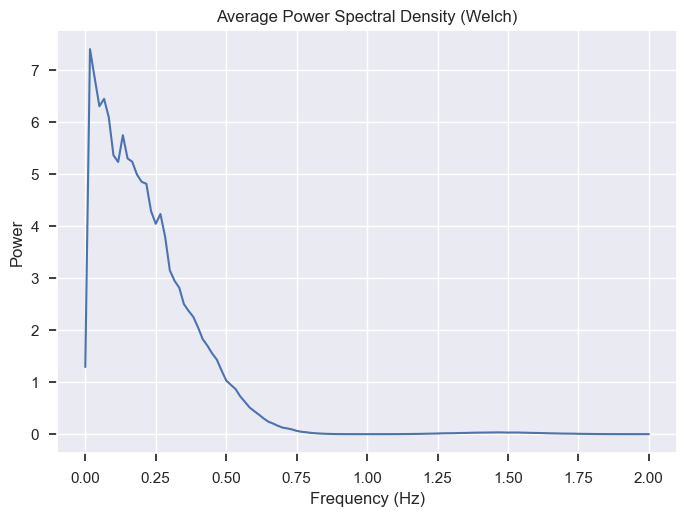

In [ ]:
input_data = preprocessed_data[['timestamp', 'heart_rate']]
freq_results = analyze_frequency_components(input_data)

print("Frequency Band Powers (averaged):")
for band, value in freq_results['bands'].items():
    print(f"{band}: {value:.4f}")

plt.plot(freq_results['frequencies'], freq_results['power'])
plt.title("Average Power Spectral Density (Welch)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid(True)
plt.show()



## 3. Time-Frequency Analysis

Implement the `analyze_time_frequency_features` function to analyze time-frequency features using wavelet transforms.

In [10]:
def analyze_time_frequency_features(data, sampling_rate=1.0, window_size=60, upsample_to=4.0):
    """
    Perform time-frequency analysis on heart_rate signal using wavelet transform.

    Parameters:
    -----------
    data : pandas.DataFrame
        Must include ['timestamp', 'heart_rate']
    sampling_rate : float
        Original sampling rate of input data (Hz)
    window_size : int
        Length of each analysis window in seconds
    upsample_to : float
        Target sampling rate in Hz for interpolation (e.g., 4.0 Hz)

    Returns:
    --------
    dict
        Dictionary containing wavelet 'scales', 'frequencies',
        averaged 'coefficients', and 'time_frequency_energy'
    """
    data = data.copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values('timestamp')
    data = data.set_index('timestamp')
    data = data[~data.index.duplicated(keep='first')]

    resample_interval = f'{int(1000 / upsample_to)}ms'
    heart_rate_interp = data['heart_rate'].resample(resample_interval).interpolate(method='linear')
    heart_rate_interp = heart_rate_interp.dropna().to_frame().reset_index()

    fs = upsample_to
    window_samples = int(window_size * fs)

    scales = np.arange(1, 128)
    frequencies = pywt.scale2frequency('morl', scales) * fs

    results = {
        'scales': scales,
        'frequencies': frequencies,
        'coefficients': None,
        'time_frequency_energy': None
    }

    n_windows = len(heart_rate_interp) // window_samples
    all_coeffs = []
    all_energy = []

    for i in range(n_windows):
        window_data = heart_rate_interp['heart_rate'].iloc[i * window_samples : (i + 1) * window_samples]

        if window_data.isnull().any() or len(window_data) < window_samples:
            continue

        coeffs, freqs = pywt.cwt(
            window_data,
            scales=scales,
            wavelet='morl',
            sampling_period=1.0 / fs
        )
        energy = np.abs(coeffs) ** 2

        all_coeffs.append(coeffs)
        all_energy.append(energy)

    if all_coeffs:
        results['coefficients'] = np.mean(all_coeffs, axis=0)
        results['time_frequency_energy'] = np.mean(all_energy, axis=0)

    return results


## Example Usage

Here's how to use these functions with your data:

In [37]:
data = pd.read_csv('/Users/hteshome/Desktop/4-it-s-about-time-haile-teshome/processed_data/S1_processed.csv')

features = extract_time_domain_features(data, window_size=60)
print("Time-domain features:")
print(features.head())

sampling_rate = 4.0  # Hz
freq_results = analyze_frequency_components(data, sampling_rate, window_size=60)
print("\nFrequency analysis results:")
print("Frequency bands:", freq_results['bands'])

tf_results = analyze_time_frequency_features(data, sampling_rate, window_size=60)
print("\nTime-frequency analysis results:")
print("Wavelet scales:", tf_results['scales'].shape)
print("Coefficients shape:", tf_results['coefficients'].shape)

Time-domain features:
            timestamp     mean_hr     std_hr  min_hr  max_hr       rmssd  \
2 2018-12-05 16:29:09   98.276667  16.834626    82.5   116.0  165.854469   
3 2018-12-05 16:29:10   95.270000  15.003220    82.5   116.0  141.791240   
4 2018-12-05 16:29:11   95.936000  13.078235    82.5   116.0  130.294292   
5 2018-12-05 16:29:12   97.863333  12.614272    82.5   116.0  118.696696   
6 2018-12-05 16:29:13  100.127143  12.979743    82.5   116.0  109.066988   

         sdnn      pnn50  mean_eda  mean_temp subject_id session  
2  105.016249  66.666667  0.008542      21.89         S1   Final  
3   93.228931  75.000000  0.011852      21.89         S1   Final  
4   82.015672  80.000000  0.014095      21.89         S1   Final  
5   79.675707  83.333333  0.015803      21.89         S1   Final  
6   80.940003  71.428571  0.016840      21.89         S1   Final  

Frequency analysis results:
Frequency bands: {'VLF': 0.054824789504861096, 'LF': 0.0015452113544484828, 'HF': 0.000105